In [1]:
import pathlib, os, shutil, cv2

"""
    base_dir: base directory
"""
def create_file_folders(base_dir=None):
    
    if base_dir == None:
        raise ValueError("base directory is empty")
        return -1
    else:
        # Create root folder
        pathlib.Path(base_dir).mkdir(parents=True, exist_ok=True)

        # Create train, validation and test directory
        train_dir = os.path.join(base_dir, 'train')
        pathlib.Path(train_dir).mkdir(parents=True, exist_ok=True)

        validation_dir = os.path.join(base_dir, 'validation')
        pathlib.Path(validation_dir).mkdir(parents=True, exist_ok=True)

        test_dir = os.path.join(base_dir, 'test')
        pathlib.Path(test_dir).mkdir(parents=True, exist_ok=True)
        print('Root folder has created with subfolders train, test and validation')
        return train_dir, validation_dir, test_dir

"""
    target_list: people list
    target_folers: default to ['train', 'validation', 'test']
    base_dir: base directory
"""
def create_target_categories(target_list=None, target_folders=['train', 'validation', 'test'], base_dir=None):
    if target_list != None:
        for directory in target_folders:
            if base_dir == None:
                raise ValueError("base directory is empty.")
            function_dir = os.path.join(base_dir, directory)
            for person in target_list:
                person = os.path.join(function_dir, person)
                pathlib.Path(person).mkdir(parents=True, exist_ok=True)
                print("Folder", person, "has ready created")
    else:
        raise ValueError('Target list is empty')

"""
    target: the person list whose photos need to be copied
    proportion: train, validation, test photos number
    base_dir: base directory
    source_target_root: the person photos directory list, this list should be the same order as target
"""
def copy_images(target=None, proportion=None, base_dir=None, source_target_dir=None):
    if target == None:
        raise ValueError("Target list is empty")
    elif source_target_dir == None:
        raise ValueError("Source Target directory list is empty")
    else:
        train_number, validation_number, test_number = proportion
        for person in target:
            photo_number = 0
            source_target = source_target_dir[target.index(person)]
            for file_name in os.listdir(source_target):
                if photo_number < train_number:
                    _copy_image_process(person, base_dir, 'train', source_target, file_name)
                elif photo_number < train_number + validation_number:
                    _copy_image_process(person, base_dir, 'validation', source_target, file_name)
                elif photo_number < train_number + validation_number + test_number:
                    _copy_image_process(person, base_dir, 'test', source_target, file_name)
                photo_number += 1

def _copy_image_process(person=None, base_dir=None, category_dir=None, source_target_dir=None, file_name=None):
    # target file
    destination_function_dir = os.path.join(base_dir, category_dir)
    destination_target_dir = os.path.join(destination_function_dir, person)
    destination_target_name = os.path.join(destination_target_dir, file_name)
    # source file
    source_target_name = os.path.join(source_target_dir, file_name)
    shutil.copyfile(source_target_name, destination_target_name)

"""
    source: source images directory
    destination: destination images directory
    angle: rotate angle
    cascadeClassifier: default face detection config,
        link: https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
"""
def extract_image(source, destination, angle, cascadeClassifier, cropped=True):
    vidcap = cv2.VideoCapture(source)

    success, image = vidcap.read()
    count, failed_count = 0, 0
    success = True
    while success:
        file_name = "frame%d.jpg" % count
        file = os.path.join(destination, file_name)
        raw_portrait_image = _rotate_image(image, angle)
        
        # whether face detection needed or not
        if cropped == True:
            portrait_image = detect_crop_face(raw_portrait_image, cascadeClassifier)
            if portrait_image is None:
                failed_count += 1
                print('photo generated failed at {}'.format(count))
            else:
                cv2.imwrite(file, portrait_image)     # save frame as JPEG file
        else:
            cv2.imwrite(file, raw_portrait_image)
        
        success, image = vidcap.read() 
        if count % 100 == 0:
            print("Generated: {} photos in {}".format(count, destination))
        count += 1
    print('Total generated {} photos'.format(count - failed_count))
    
def _rotate_image(image, angle):
    # rotate image some degree
    height, width = image.shape[:2]
    image_center = (width/2, height/2)
    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    rotated_image = cv2.warpAffine(image, rotation_mat, (bound_w, bound_h))
    return rotated_image

"""
    Detect face in image, extract and return the face image.
    image: the raw photo which contains the face
    faceCascade: face cascade xml config file,
        link: https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
"""
def detect_crop_face(image, faceCascade):
    face_cascade = cv2.CascadeClassifier(faceCascade)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if faces == ():
        return None
    else:
        for (x,y,w,h) in faces:
            return image[y:y+h, x:x+w]

In [ ]:
cascadeClassifier = 'haarcascade_frontalface_default.xml'

source_meiyu = 'meiyu.mp4'
destination_meiyu = 'meiyu'
pathlib.Path(destination_meiyu).mkdir(parents=True, exist_ok=True)
extract_image(
    source=source_meiyu,
    destination=destination_meiyu,
    angle=-90,
    cascadeClassifier=cascadeClassifier)

source_zhangxin = 'zhangxin.mp4'
destination_zhangxin = 'zhangxin'
pathlib.Path(destination_zhangxin).mkdir(parents=True, exist_ok=True)
extract_image(
    source=source_zhangxin,
    destination=destination_zhangxin,
    angle=-90,
    cascadeClassifier=cascadeClassifier)

source_xingda = 'xingda.mp4'
destination_xingda = 'xingda'
pathlib.Path(destination_xingda).mkdir(parents=True, exist_ok=True)
extract_image(
    source=source_xingda,
    destination=destination_xingda,
    angle=90,
    cascadeClassifier=cascadeClassifier)

In [3]:
base_dir="faces"
people = ['julie', 'xingda', 'melanie']
proportion = [200, 50, 50]
source_target_dir = people

train_dir, validation_dir, test_dir = create_file_folders(base_dir)
create_target_categories(people, base_dir=base_dir)
copy_images(people, proportion, base_dir, source_target_dir)

Root folder has created with subfolders train, test and validation
Folder faces/train/julie has ready created
Folder faces/train/xingda has ready created
Folder faces/train/melanie has ready created
Folder faces/validation/julie has ready created
Folder faces/validation/xingda has ready created
Folder faces/validation/melanie has ready created
Folder faces/test/julie has ready created
Folder faces/test/xingda has ready created
Folder faces/test/melanie has ready created


In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

num_classes = 3
height = 150
width = 150
batch_size = 16

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(width, height, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 148, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        18496     
__________

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import keras

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='categorical')

callback_list = [
    # interrupts training when improving stops
    keras.callbacks.EarlyStopping(
        # monitor the model's validation accuracy
        monitor='acc',
        # patience=1 => interrupt training when accuracy has stoped improving for more than 1 epoch (that is 2 epoch)
        patience=3),
    
    # save the current weights after every epoch
    keras.callbacks.ModelCheckpoint(
        # path to the destination model file
        filepath='face_recognition.h5',
        # won't overwrite the model unless val_loss has improved.
        monitor='val_loss',
        save_best_only=True),
    
    # Use tensorboard to analysis result
    keras.callbacks.TensorBoard(
        log_dir='graph/train',
        histogram_freq=0,
        write_graph=True)
]

model.compile(
    loss='binary_crossentropy',
#     optimizer=optimizers.RMSprop(lr=1e-4),
    optimizer=optimizers.Adam(amsgrad=True),
    metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=callback_list,
    workers=-1
)

# save model
model_json_file = model.to_json()
with open("face_recognition_model.json", "w") as json_file:
    json_file.write(model_json_file)

Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Epoch 1/50
100/100 [==============================] - 114s 1s/step - loss: 0.5583 - acc: 0.7017 - val_loss: 0.4875 - val_acc: 0.7022
Epoch 2/50
100/100 [==============================] - 107s 1s/step - loss: 0.3009 - acc: 0.8619 - val_loss: 0.3452 - val_acc: 0.8756
Epoch 3/50
100/100 [==============================] - 109s 1s/step - loss: 0.1352 - acc: 0.9550 - val_loss: 0.5155 - val_acc: 0.8178
Epoch 4/50
100/100 [==============================] - 109s 1s/step - loss: 0.1779 - acc: 0.9411 - val_loss: 0.1636 - val_acc: 0.9489
Epoch 5/50
100/100 [==============================] - 108s 1s/step - loss: 0.0947 - acc: 0.9690 - val_loss: 0.2214 - val_acc: 0.9378
Epoch 6/50
100/100 [==============================] - 110s 1s/step - loss: 0.0685 - acc: 0.9810 - val_loss: 0.0224 - val_acc: 0.9911
Epoch 7/50
100/100 [==============================] - 110s 1s/step - loss: 0.0902 - acc: 0.9700 - val_loss: 0.0483 - val

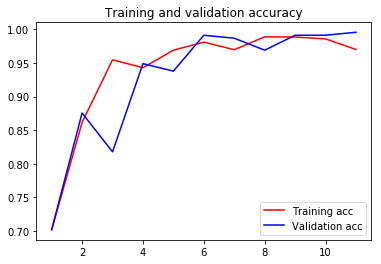

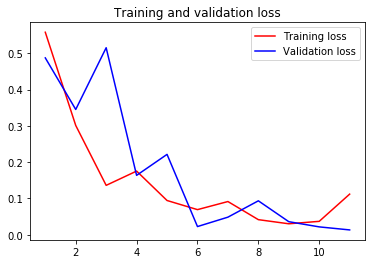

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [8]:
train_generator.class_indices

{'julie': 0, 'melanie': 1, 'xingda': 2}

In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import numpy as np
import os


count = 0
CascadeClassifier = '/Users/xingda/Desktop/haarcascade_frontalface_default.xml'
for photo_name in os.listdir('/Users/xingda/Desktop/xingda_ori/'):
    photo_path = os.path.join('/Users/xingda/Desktop/xingda_ori/', photo_name)
    photo = cv2.imread(photo_path)
    face = detect_crop_face(photo, CascadeClassifier)
    file_name = "xingda%d.jpg" % count
    file = os.path.join('/Users/xingda/Desktop/test', file_name)
    cv2.imwrite(file, face)
    count += 1
print('xingda image is done')

count = 0
CascadeClassifier = '/Users/xingda/Desktop/haarcascade_frontalface_default.xml'
for photo_name in os.listdir('/Users/xingda/Desktop/meiyu_ori/'):
    photo_path = os.path.join('/Users/xingda/Desktop/meiyu_ori/', photo_name)
    photo = cv2.imread(photo_path)
    face = detect_crop_face(photo, CascadeClassifier)
    file_name = "meiyu%d.jpg" % count
    file = os.path.join('/Users/xingda/Desktop/test', file_name)
    cv2.imwrite(file, face)
    count += 1
print('meiyu image is done')
    
count = 0
CascadeClassifier = '/Users/xingda/Desktop/haarcascade_frontalface_default.xml'
for photo_name in os.listdir('/Users/xingda/Desktop/zhangxin_ori/'):
    photo_path = os.path.join('/Users/xingda/Desktop/zhangxin_ori/', photo_name)
    photo = cv2.imread(photo_path)
    face = detect_crop_face(photo, CascadeClassifier)
    file_name = "zhangxin%d.jpg" % count
    file = os.path.join('/Users/xingda/Desktop/test', file_name)
    cv2.imwrite(file, face)
    count += 1
print('zhangxin image is done')

In [9]:
from keras.preprocessing import image
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import numpy as np
import os


total = 0
error = 0
test_path = '/Users/xingdawang/Desktop/test/'

for photo in os.listdir(test_path):
    photo_path = os.path.join(test_path, photo)
    try:
        img = image.load_img(photo_path, target_size=(width, height))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x /= 255.
        classes = model.predict_classes(x)

        if classes[0] == 0:#meiyu
            print(photo, "\tpredicted as meiyu\t", "meiyu" in photo)
            if "meiyu" not in photo:
                error += 1
        elif classes[0] == 1:
            print(photo, "\tpredicted as xingda\t", "xingda" in photo)
            if "xingda" not in photo:
                error += 1
        elif classes[0] == 2:
            print(photo, "\tpredicted as zhangxin\t", "zhangxin" in photo)
            if "zhangxin" not in photo:
                error += 1
        total += 1
    except:
        print("Cannot load", photo_path)
print("Total test:", total)
print("Total error:", error)
print("correct pct:", (total - error)/total)

zhangxin3.jpg 	predicted as zhangxin	 True
xingda22.jpg 	predicted as xingda	 True
xingda23.jpg 	predicted as xingda	 True
zhangxin2.jpg 	predicted as zhangxin	 True
zhangxin0.jpg 	predicted as zhangxin	 True
xingda21.jpg 	predicted as xingda	 True
zhangxin1.jpg 	predicted as zhangxin	 True
zhangxin5.jpg 	predicted as zhangxin	 True
xingda18.jpg 	predicted as xingda	 True
xingda24.jpg 	predicted as xingda	 True
xingda25.jpg 	predicted as xingda	 True
xingda19.jpg 	predicted as xingda	 True
zhangxin4.jpg 	predicted as zhangxin	 True
zhangxin6.jpg 	predicted as zhangxin	 True
xingda26.jpg 	predicted as xingda	 True
zhangxin7.jpg 	predicted as zhangxin	 True
zhangxin11.jpg 	predicted as zhangxin	 True
zhangxin39.jpg 	predicted as zhangxin	 True
meiyu19.jpg 	predicted as meiyu	 True
meiyu25.jpg 	predicted as meiyu	 True
meiyu24.jpg 	predicted as meiyu	 True
meiyu18.jpg 	predicted as meiyu	 True
zhangxin38.jpg 	predicted as zhangxin	 True
zhangxin10.jpg 	predicted as zhangxin	 True
xingda9.

In [28]:
model.predict(x).reshape(-1)

array([1.2124736e-08, 9.9804842e-01, 1.9515771e-03], dtype=float32)